# crms_repr-celltype-pattern_rec


THis is an update of `crms_repr-celltype-pattern_rec`, `crms_representation-cell-type-specific.ipynb`, focused on find patterns found in the data,

6/10/2020

test cell-type specific prediction

todo
- test model performance with only certan parameters
- edit the model type
- set up sequence information

# 0. startup


In [2]:
import os, glob
import itertools
from collections import Counter, defaultdict
import time

import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt

from scipy import interp

from scipy.stats.stats import pearsonr
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
save_dir = '../data/processed/fig4_modelling_expr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
THRES=1
rna_tpm_file = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file, index_col=0,header=0)
rna_df.index = [x.upper() for x in rna_df.index.values]
all_genes = rna_df.index

def get_exp(rna_df, sym, tissue,verbose=True):
    try:
        return rna_df.loc[sym,tissue]
    except KeyError:
        if verbose:
            print(sym, 'not found')
        return 0
    
    
rna_df_log = np.log(rna_df + 1e-2)

In [6]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal',#'GDSD0','GDSD3',
                  'GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

In [7]:
# hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
# hoco_annon = pd.read_table(hoco_annon_file,header=0)
# hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
# hoco_motif_t|o_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
# tfs = list(hoco_annon['Transcription factor'])

#  1. Data preprocessing and importing

iteracte through and choose different feature versions to find best)

found comb > ?prom?, ?sep > sum

In [8]:
save_prefix = 'comb_all' # comb >~ sep > prom > sum
data_type = 'comb'

In [9]:
%%time
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
# data_all = pd.read_csv('../data/processed/tissue_crms_random/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(normal_tissues)]
print(data_all.shape)
# # filter for crms with data, 
# data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
# print(data_all.shape)


(372165, 1063)
CPU times: user 1min 34s, sys: 24.5 s, total: 1min 58s
Wall time: 1min 43s


In [10]:
exp_label = data_all.exp.values
exp_label_bin  = np.array(np.array(exp_label)>THRES)



#### preprocess genes by converting into number

In [11]:
genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)
len(np.unique(genes_all))

24811

15476 genes usually have data

for gex prediction use all data

#### preprocess tissues

In [12]:
tissue_labels = data_all.tissue.values
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values
tissue_labels.shape

(372165,)

In [13]:
Counter(tissue_labels)

Counter({'Airway': 24811,
         'Astrocytes': 24811,
         'Bladder': 24811,
         'Colon': 24811,
         'Esophageal': 24811,
         'GDSD6': 24811,
         'GM12878': 24811,
         'HMEC': 24811,
         'Melanocytes': 24811,
         'Ovarian': 24811,
         'Pancreas': 24811,
         'Prostate': 24811,
         'Renal': 24811,
         'Thyroid': 24811,
         'Uterine': 24811})

In [14]:
## only tfs
# for tf only version, scale each tf feature by its expression value

data_all.drop(['num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape


(372165, 1059)

In [15]:
# ensure tfs are in right order
prev_tissue=''
for i,tissue in enumerate(data_all.tissue.values):
    if prev_tissue!=tissue:
        print(i,tissue)
        prev_tissue=tissue

0 Airway
24811 Astrocytes
49622 Bladder
74433 Colon
99244 Esophageal
124055 GDSD6
148866 GM12878
173677 HMEC
198488 Melanocytes
223299 Ovarian
248110 Pancreas
272921 Prostate
297732 Renal
322543 Thyroid
347354 Uterine


In [16]:
%%time
# get the tf expression in ther right matrix format
tf_order_arr = []
tf_tissue_exp = {}
for feature in data_all.columns.values[2:]:
    tf = feature.split('_')[0]
    tf_order_arr.append(tf)
    tf_tissue_exp[tf]=rna_df.loc[tf,:].to_dict()
    
exp_mat = np.zeros((data_all.shape[0], data_all.shape[1]-2))
prev_tissue_counter = 0
for tissue, num_crm_for_tissue in Counter(tissue_labels).items():
    tf_exp_arr = [tf_tissue_exp[tf][tissue] for tf in tf_order_arr]
    exp_mat[prev_tissue_counter:prev_tissue_counter+num_crm_for_tissue,:] = tf_exp_arr
    prev_tissue_counter+=num_crm_for_tissue
    
# drop tissue column and multiply
data_all.drop(['tissue','exp'],axis=1,inplace=True)
data_all= data_all*exp_mat
print(data_all.shape)


(372165, 1057)
CPU times: user 6.62 s, sys: 4.2 s, total: 10.8 s
Wall time: 4.62 s


In [17]:

# filter for crms with data, 
exp_label = exp_label[~data_all.index.isin(tf_order_arr)]
exp_label_bin  = np.array(exp_label>THRES)

genes_all = genes_all[~data_all.index.isin(tf_order_arr)]
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)
len(np.unique(genes_all))

tissue_labels = tissue_labels[~data_all.index.isin(tf_order_arr)]
tissue_num_labels = tissue_num_labels[~data_all.index.isin(tf_order_arr)]

data_all = data_all[~data_all.index.isin(tf_order_arr)]

# exp_label = exp_label[data_all.sum(axis=1)>1e-1]
# exp_label_bin  = np.array(exp_label>THRES)

# genes_all = genes_all[data_all.sum(axis=1)>1e-1]
# gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
# genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)
# len(np.unique(genes_all))

# tissue_labels = tissue_labels[data_all.sum(axis=1)>1e-1]
# tissue_num_labels = tissue_num_labels[data_all.sum(axis=1)>1e-1]

# data_all = data_all[data_all.sum(axis=1)>1e-1]

print(data_all.shape)



(364230, 1057)


In [19]:
data_all['exp']  =exp_label
data_all['tissue'] = tissue_labels
data_all.to_csv('../data/processed/tissue_crms/all_count_'+'tfexpr_weighted_comb' +'_overall.csv')

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,ATF7_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# rna_exp_arr = []
# for i in range(data_all.shape[0]):
#     try:
#         rna_exp_arr.append(rna_df_log.loc[data_all.index[i],tissue_labels[i]])
#     except:
#         rna_exp_arr.append(0)
# rna_exp_bin  = np.array(np.array(rna_exp_arr)>THRES)


In [18]:
# rna_df_log.index

In [19]:
# Counter(rna_exp_bin==exp_label_bin)

In [20]:
# sns.distplot(np.array(rna_exp_arr) - np.array(exp_label))

In [21]:
# # normal version
# data_all['tissue']=tissue_num_labels
# if 'exp' in data_all.columns:
#     data_all.drop('exp',axis=1,inplace=True)
# data_all['gene_num'] = genes_num_all
   
# data_all.shape




In [33]:
data_all.columns

Index(['AHR_pro', 'ARID5B_pro', 'ARNT_pro', 'ARNTL_pro', 'ATF1_pro',
       'ATF2_pro', 'ATF3_pro', 'ATF4_pro', 'ATF6_pro', 'ATF7_pro',
       ...
       'MAFA_loop', 'MEOX1_loop', 'E2F5_pro', 'E2F5_loop', 'ESR2_pro',
       'KLF14_pro', 'TBX15_pro', 'ESR2_loop', 'KLF14_loop', 'TBX15_loop'],
      dtype='object', length=1057)

In [32]:
%%time
# preprocessing, remove zero variance columns, and scale rest of columns 
    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(364230, 1057) (364230, 980) 980
(364230, 980) (364230, 980)
CPU times: user 16.1 s, sys: 3.78 s, total: 19.9 s
Wall time: 13.2 s


In [25]:
%%time 
clf1 = LogisticRegression(random_state=1)
scores = cross_val_score(clf1, data_all, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Regression'))

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Accuracy: 0.65 (+/- 0.01) [Logistic Regression]
CPU times: user 11min 34s, sys: 8.49 s, total: 11min 42s
Wall time: 1min 31s


In [26]:
%%time 
clf1 = LogisticRegression(random_state=1)
scores = cross_val_score(clf1, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Regression'))

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Accuracy: 0.64 (+/- 0.01) [Logistic Regression]
CPU times: user 10min 41s, sys: 8.89 s, total: 10min 50s
Wall time: 1min 27s


In [34]:
%%time 
clf2 = RandomForestClassifier(n_estimators=50, 
                               max_features = 'sqrt',
#                                max_depth=5,
                               n_jobs=-1, verbose = 0)
scores = cross_val_score(clf2, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest'))

KeyboardInterrupt: 

In [35]:
%%time 
clf2 = RandomForestClassifier(n_estimators=50, 
                               max_features = 'sqrt',
#                                max_depth=5,
                               n_jobs=-1, verbose = 0)
scores = cross_val_score(clf2, data_all, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest'))

KeyboardInterrupt: 

In [36]:
%%time
clf3 = GaussianNB()
scores = cross_val_score(clf3, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Gaussian NB'))

scores = cross_val_score(clf3, data_all, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Gaussian NB'))



KeyboardInterrupt



In [37]:
%%time
clf4 = LinearSVC(random_state=0, tol=1e-5)
scores = cross_val_score(clf4, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'LinearSVC'))

clf4 = LinearSVC(random_state=0, tol=1e-5)
scores = cross_val_score(clf4, data_all, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'LinearSVC'))


KeyboardInterrupt



In [39]:
%%time


#doesn't work
clf5 = LassoCV() or # Lasso()
scores = cross_val_score(clf5, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Lasso'))

SyntaxError: EOL while scanning string literal (<unknown>, line 1)

In [49]:
%%time
clf8 = MLPClassifier()
scores = cross_val_score(clf8, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'MLP NN'))

clf8 = MLPClassifier()
scores = cross_val_score(clf8, data_all, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'MLP NN'))


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

Log when don't tf correct
sum_all: Accuracy: 0.52 (+/- 0.03) [Random Forest]
comb_all: Accuracy: 0.58 (+/- 0.02) [Random Forest]
comb_all: Accuracy: 0.55 (+/- 0.01) [Logistic Regression]
comb_tf_only: Accuracy: 0.55 (+/- 0.01) [Logistic Regression]
comb_random: Accuracy: 0.53 (+/- 0.01) [Logistic Regression]


when tf correct non normalized data
Accuracy: 0.65 (+/- 0.01) [Logistic Regression]
nomralize data
Accuracy: 0.64 (+/- 0.00) [Logistic Regression]
Accuracy: 0.65 (+/- 0.02) [Random Forest]

# 2. Data Exploration

## A. Correlation

In [52]:
data_all['log_exp'] = np.log(np.array(exp_label)+1e-2)

corr_df = pd.DataFrame({'feature':data_all.columns.values})
corr_df['cor'] = corr_df.feature.apply(lambda x: data_all['log_exp'].corr(data_all[x]))
# for column in data_all.columns.values:
#     print(column, data_all['log_exp'].corr(data_all[column]))

In [53]:
corr_df.sort_values('cor',ascending=False)[:20]

,feature,cor
1057,log_exp,1.000000
586,UBP1_loop,0.186858
477,NFIA_loop,0.183250
548,SP3_loop,0.172823
615,ZNF281_loop,0.168715
594,ZBTB17_loop,0.166151
454,MAZ_loop,0.165605
546,SP1_loop,0.165232
612,ZNF263_loop,0.163421
541,SOX13_loop,0.163353


CPU times: user 8.38 s, sys: 2.14 s, total: 10.5 s
Wall time: 9.58 s


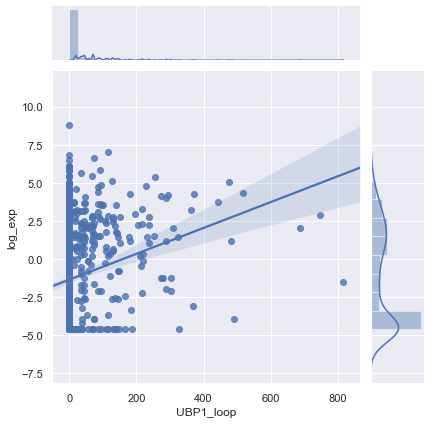

In [55]:
%%time
sns.jointplot("UBP1_loop", "log_exp", data=data_all.iloc[np.random.choice(range(data_all.shape[0]),1000),:], kind="reg")#,

In [338]:
pd.Series(np.log(np.array(exp_label)+1e-2)).describe()

count    132365.000000
mean          0.610193
std           3.082495
min          -4.605170
25%          -1.660731
50%           1.193922
75%           2.836150
max          10.838918
dtype: float64

[[1.         0.03717474]
 [0.03717474 1.        ]]


RuntimeError: In set_text: could not load glyph

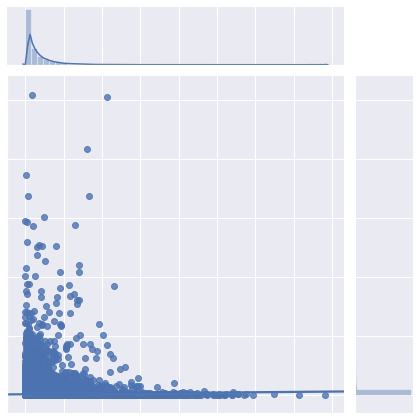

In [336]:
g = sns.jointplot(data_all.sum(axis=1), exp_label, kind="reg")#,
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
print(np.corrcoef(data_all.sum(axis=1),exp_label))
plt.savefig(os.path.join(save_dir,'exp_v_sumfeat.pdf'))

0.016234636324868396


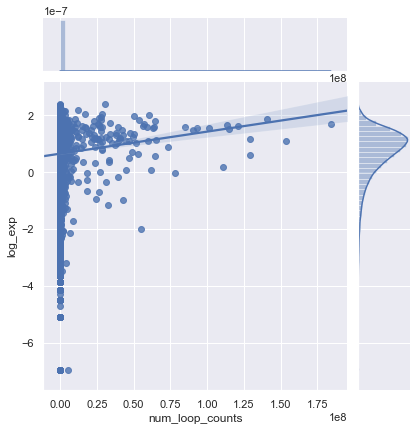

In [79]:
g = sns.jointplot("num_loop_counts", "log_exp", data=data_all, kind="reg")#,
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
print(data_all['log_exp'].corr(data_all['num_loop_counts']))
plt.savefig(os.path.join(save_dir,'log_exp_v_num_loop_counts.pdf'))

0.06896513463389654


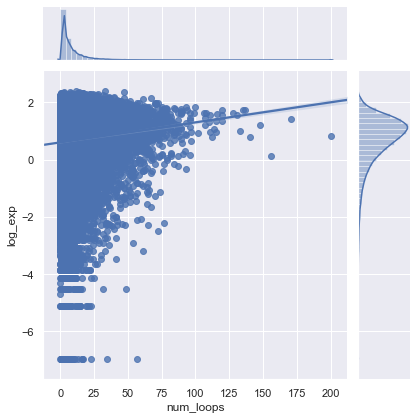

In [80]:
g2 = sns.jointplot("num_loops", "log_exp", data=data_all, kind="reg")#,
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
print(data_all['log_exp'].corr(data_all['num_loops']))
plt.savefig(os.path.join(save_dir,'log_exp_v_num_loops.pdf'))

0.07220444914258531


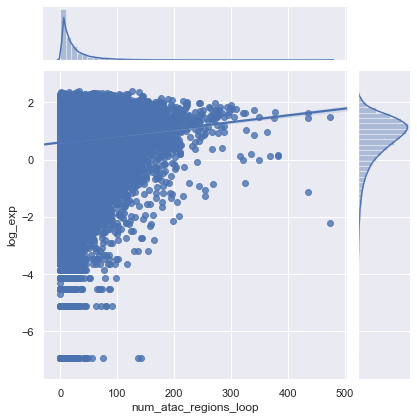

In [81]:
g3 = sns.jointplot("num_atac_regions_loop", "log_exp", data=data_all, kind="reg")#,
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
print(data_all['log_exp'].corr(data_all['num_atac_regions_loop']))
plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_loop.pdf'))

0.01524519412805702


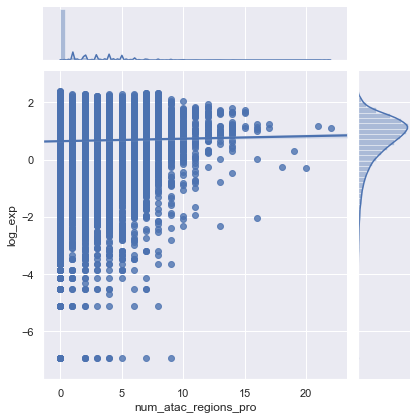

In [82]:
g4 = sns.jointplot("num_atac_regions_pro", "log_exp", data=data_all, kind="reg")#,
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
print(data_all['log_exp'].corr(data_all['num_atac_regions_pro']))
plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_pro.pdf'))

In [12]:
# %%time
# sns.pairplot(data_all[["num_loops", "num_loop_counts", "num_snp", "num_atac_regions"]], diag_kind="kde")#,kind="reg")
# plt.savefig(os.path.join(save_dir,'pairplot_main_count_feats.png'))

## 2A: Classification:
#### data split

In [45]:
# Split the data into training and testing sets

chosen_data_len = int(data_all_norm.shape[0]/5)
chosen_data_idx = np.random.choice(range(data_all_norm.shape[0]),chosen_data_len,replace=False)

train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm[chosen_data_idx,:], exp_label_bin[chosen_data_idx],
                                                                            test_size = 0.25, random_state = 80)
 

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())
Counter(test_labels)

Training Features Shape: (54634, 980)
Training Labels Shape: (54634,)
Testing Features Shape: (18212, 980)
Testing Labels Shape: (18212,)


Counter({True: 7514, False: 10698})

In [44]:
# del exp_mat
# del rna_df
# del rna_df_log

#### 1. Random Forest

In [109]:
# clf1 = RandomForestClassifier(n_estimators=100, 
#                                max_features = 'sqrt',
# #                                max_depth=5,
#                                n_jobs=-1, verbose = 0)
# scores = cross_val_score(clf1, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest'))

In [46]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
#                                max_depth=5,
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 13min 3s, sys: 6.21 s, total: 13min 9s
Wall time: 59.8 s


In [47]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs[:,1])#, multi_class='ovo')
print(roc_value)


0.6784537667471996
0.6524072432524907


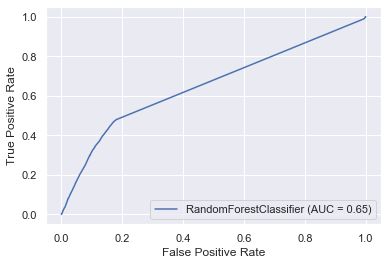

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs[:,1], pos_label=1)
# fig, ax = plt.subplots()
# ax.plot(fpr,tpr)
plot_roc_curve(model, test_features, test_labels)#, multi_class='ovr') 

CPU times: user 20min 19s, sys: 26.2 s, total: 20min 45s
Wall time: 2min 42s


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


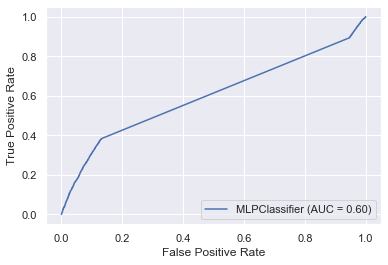

In [50]:
%%time
clf8 = MLPClassifier()
clf8.fit(train_features, train_labels)
probs = clf8.predict_proba(test_features)
# roc_value = roc_auc_score(test_labels, rf_probs[:,1])#, multi_class='ovo')
plot_roc_curve(clf8, test_features, test_labels)#, multi_class='ovr') 
# scores = cross_val_score(clf8, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'MLP NN'))


In [77]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.to_csv(os.path.join(save_dir, save_prefix+'_feature_importance.csv'))

# Display
fi.head(10)

,feature,importance
1,num_loop_counts,0.028073
4,num_atac_regions_loop,0.024351
0,tissue,0.021998
2,num_loops,0.020877
569,UBP1_loop,0.010717
311,ARID5B_loop,0.009242
526,SOX13_loop,0.009230
442,MAZ_loop,0.008282
572,VEZF1_loop,0.008029
3,num_atac_regions_pro,0.007869


### 2 - test different models

In [106]:
%%time
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Accuracy: 0.55 (+/- 0.00) [Logistic Regression]
Accuracy: 0.58 (+/- 0.01) [Random Forest]
Accuracy: 0.52 (+/- 0.01) [naive Bayes]


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Accuracy: 0.57 (+/- 0.01) [Ensemble]
CPU times: user 15min 18s, sys: 10.4 s, total: 15min 28s
Wall time: 7min 17s


Results (takes about 30 min)
- Accuracy: 0.70 ( [Logistic Regression]
- Accuracy: 0.77 (+/- 0.01) [Random Forest]
- Accuracy: 0.64 (+/- 0.02) [naive Bayes]
- Accuracy: 0.72 (+/- 0.02) [Ensemble]

In [84]:
%%time
clf4 = LinearSVC(random_state=0, tol=1e-5)
scores = cross_val_score(clf4, data_all_norm, exp_label_bin, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'LinearSVC'))

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.55 (+/- 0.00) [LinearSVC]


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.55 (+/- 0.00) [LinearSVC]


In [54]:
# doesn't work
# clf5 = LassoCV() or # Lasso()
# scores = cross_val_score(clf5, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Lasso'))

In [ ]:
# knn too slow
# clf6 = KNeighborsClassifier(n_neighbors=5)
# scores = cross_val_score(clf6, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'KNN'))

In [110]:
# %%time
# clf7 = AdaBoostClassifier(n_estimators=100, random_state=0)
# scores = cross_val_score(clf7, data_all_norm, labels_all_bin, scoring='accuracy', cv=3)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'AdaBoost'))
# # >>> clf.fit(X, y)
# # AdaBoostClassifier(n_estimators=100, random_state=0)
# # >>> clf.feature_importances_
# # array([0.28..., 0.42..., 0.14..., 0.16...])
# # >>> clf.predict([[0, 0, 0, 0]])
# # array([1])
# # >>> clf.score(X, y)

In [107]:
# %%time
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf4 = LinearSVC(random_state=0, tol=1e-5)
# eclf = VotingClassifier(
#     estimators=[('lr', clf1), ('rf', clf2), ('svc', clf4)],
#     voting='hard')

# for clf, label in zip([eclf], ['Ensemble2']):
#     scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=3)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.70 (+/- 0.02) [Ensemble2]


###  Neural network classifers (skllearn and other)

In [108]:
%%time
clf8 = MLPClassifier()
scores = cross_val_score(clf8, data_all_norm, exp_label_bin, scoring='accuracy', cv=3)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'MLP NN'))


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.58 (+/- 0.01) [MLP NN]
CPU times: user 1h 44min 25s, sys: 2min 25s, total: 1h 46min 50s
Wall time: 15min


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 [MLP NN]


In [ ]:
###  Neural network classifers (tensorflow)

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, labels_all_bin,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


In [ ]:
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(train_features.shape[1],)),
    keras.layers.Dense(64, activation='relu', input_shape=[train_features.shape[1]]),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='softmax')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


In [ ]:
model.fit(train_features, train_labels, epochs=10)


In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
# regression
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, np.array(labels_all), 
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[train_features.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [ ]:
model = build_model()
model.summary()


In [ ]:
%%time
EPOCHS = 100#0
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(
  train_features, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

# history = model.fit(train_features, train_labels, 
#             epochs=EPOCHS, validation_split = 0.2, verbose=0, 
#             callbacks=[early_stop, tfdocs.modeling.EpochDots()])



model = build_model()





In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 10])
plt.ylabel('MAE ')

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE')

## 2B: Regression
Lasso, 


In [ ]:
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, np.array(labels_all), test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Baseline errors, and display average baseline error
baseline_errors = abs(labels_all_bin - np.mean(labels_all))
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [ ]:
%%time
# Import the model we are using
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_depth=5,random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))


In [ ]:
test_labels

In [ ]:
Counter(predictions)

In [ ]:


# Pull out one tree from the forest
tree = rf.estimators_[5]

# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('networks/representations/tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'networks/representations/small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('networks/representations/small_tree.dot')
graph.write_png('networks/representations/small_tree.png');

In [ ]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(train_features.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()


In [ ]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
test_labels_num = np.vectorize(normal_tissues_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(model.classes_[i], roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), rf_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print('micro average', roc_auc["micro"])

In [ ]:
normal_tissues_dict

In [ ]:
# saving
auc_df = pd.DataFrame.from_dict({'tissue':list(model.classes_)+['micro'],'LOO-AUROC': list(roc_auc.values())},orient='columns')
auc_df.to_csv(os.path.join(save_dir, save_prefix+'_auc_tissue.csv'))



In [ ]:
# saving tpr 
pd.DataFrame.from_dict({'fpr':fpr["micro"],'tpr': tpr["micro"]},orient='columns').to_csv(os.path.join(save_dir, save_prefix+'_auc_curve_values.csv'))

In [ ]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
np.std(list(roc_auc.values()))

In [ ]:
conf_mat = confusion_matrix(test_labels, rf_predictions)
df_confmat = pd.DataFrame(conf_mat, index = model.classes_,
                  columns = model.classes_)
display(df_confmat)

In [ ]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat/df_confmat.sum(axis=0), annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, save_prefix + '_df_confmat.pdf'),pad_inches=0.4)

### 2A.1 - testing amount of data



In [ ]:
# def test_data_amt(data_mat, label_arr, perc_acc, )

In [ ]:
%%time
tot_data = len(data_all_norm)
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm[chosen_data_idx,:], 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)


In [ ]:
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, save_prefix+'_eval_df.csv'))

In [ ]:

data_chosen

In [ ]:
# %%time
# rna info only
tot_data = len(data_all_norm)
column_chosen =[0,data_all_norm.shape[1]-1] # exp, num_gene
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    data_chosen = data_all_norm[chosen_data_idx,:]
    data_chosen = data_chosen[:,column_chosen].reshape((chosen_data_len, len(column_chosen)))

    train_features, test_features, train_labels, test_labels = train_test_split(data_chosen, 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, 'rna_eval_df.csv'))

In [ ]:
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
# type_to_legend_mapping = {
#     'sep':a
# }
for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_')[0]
    eval_df = pd.read_csv(filepath)
    sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type.pdf'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label='tf_with_hichip')

In [ ]:
# sns.lineplot(x="perc", y="roc", data= pd.DataFrame.from_dict({'perc':perc_arr, 'roc':roc_arr}, orient='columns'))

comb_eval_df = pd.read_csv(os.path.join(save_dir, 'comb_eval_df.csv'))
prom_eval_df = pd.read_csv(os.path.join(save_dir, 'prom_eval_df.csv'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=comb_eval_df,
           logx=True,ax=ax,label='with looping')
sns.regplot(x="perc", y="auc",data=prom_eval_df,
           logx=True,ax=ax,color='darkred',label='no looping')
ax.legend()
ax.set_xlabel('% of data')
fig.savefig(os.path.join(save_dir, '6A_eval_data_type_looping.pdf'))

In [ ]:
prom_eval_df


In [ ]:
comb_auc_df = pd.read_csv(os.path.join(save_dir, 'comb_auc_curve_values.csv'))
prom_auc_df = pd.read_csv(os.path.join(save_dir, 'prom_auc_curve_values.csv'))
print(comb_auc_df.shape)
# with plt.style.context("seaborn-white"):
#     plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(5,4),dpi=300)
ax.set_facecolor('white')
ax.plot(comb_auc_df['fpr'], comb_auc_df['tpr'],'b-',label='with looping, AUC: 0.90 +/- 0.02')
ax.plot(prom_auc_df['fpr'], prom_auc_df['tpr'],'r-',label='no looping, AUC: 0.68 +/- 0.01')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim(-0.01,1)
ax.set_ylim(-0.01,1.01)

ax.plot([0, 1.1], [0, 0], 'k')
ax.plot([0, 0], [0, 1.1], 'k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# sns.scatterplot(x="fpr", y="tpr",data=comb_auc_df,
#                 marker=False,'-',
#            ax=ax,label='with looping')
# sns.scatterplot(x="fpr", y="tpr",data=prom_auc_df,
#                 marker=False,'-',
#            ax=ax,color='darkred',label='no looping')
ax.legend(loc='lower right',facecolor='white')
fig.savefig(os.path.join(save_dir, 'auc_comb_pro.pdf'))

In [ ]:
# %%time
# cv_results = cross_validate(clf, data_all_norm, labels_all_bin, groups = gene_groups, 
#                scoring=['accuracy', 'f1', 'roc_auc','precision', 'recall'])

In [ ]:
# for key, list_res in cv_results.items():
#     print(key, "%.2f +/- %.2f" % (list_res.mean(), list_res.std()))

In [ ]:
# scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest per gene'))


### 2A.2 - test different models

### 2A - only atac or only hichip

In [ ]:
data_all_varfilt_cols

In [ ]:
atac_rna_foot_cols = data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')] + ['num_atac_regions']+ ['num_snp'] + ['log_exp'] + ['gene_num']
atac_rna_foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) + list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])+ list(np.where(data_all_varfilt_cols=='num_snp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='log_exp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='gene_num')[0])

len(atac_rna_foot_col_idx)
    

In [ ]:
hichip_only_cols = ['num_loop_counts', 'num_loops']
hichip_only_col_idx = list(np.where(data_all_varfilt_cols=='num_loop_counts')[0])+list(np.where(data_all_varfilt_cols=='num_loops')[0])



In [ ]:
atac_only_cols = ['num_atac_regions']
atac_only_col_idx = list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])


In [ ]:
rna_only_cols = ['log_exp', 'gene_num']
rna_only_col_idx = list(np.where(data_all_varfilt_cols=='log_exp')[0])+list(np.where(data_all_varfilt_cols=='gene_num')[0])


In [ ]:
foot_cols = list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')]) + list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])
foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) 
foot_col_idx+=   list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])[0]) 
len(foot_col_idx)
    

In [ ]:
all_indices = list(range(len(data_all_varfilt_cols)))

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


In [ ]:
test_labels_num = np.vectorize(tissue_to_num_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [ ]:
indices_to_test = [all_indices, hichip_only_col_idx, rna_only_col_idx, atac_only_col_idx, foot_col_idx, atac_rna_foot_col_idx]
test_name = ['All', 'HiChIP', 'RNA', 'ATAC', 'footprinting+looping', 'RNA+ATAC+footprinting']

In [ ]:
train_features[:,hichip_only_col_idx].shape

In [ ]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['data_type', 'fpr','tpr','auc'])
result_model_dict = {}
# Train the models and record the results
for idx_list, name in zip(indices_to_test, test_name):
    print(name)
    model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0).fit(train_features[:, idx_list], train_labels)
    yproba = model.predict_proba(test_features[:, idx_list])

    # get micro roc-auc for each type of data
    fpr, tpr, _ = roc_curve(test_labels_bin.ravel(),  yproba.ravel())
    
    
    auc = roc_auc_score(test_labels, yproba, multi_class='ovo')
    print(auc)
    result_model_dict[name] = model
    result_table = result_table.append({'data_type':name, #'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the data_type as index labels
result_table.set_index('data_type', inplace=True)

In [ ]:
result_table.reset_index(inplace=True)
result_table.at[4,'data_type']= 'footprinting+looping'
result_table.set_index('data_type',inplace=True)

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# 4 Clustering

Dimensionality reduction 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [ ]:
groups_dict = {'Airway':'purple',
 'Astrocytes':'blue',
 'Bladder':'purple',
 'Colon':'green',
 'Esophageal':'green',
 'GDSD0':'purple',
 'GDSD3':'purple',
 'GDSD6':'purple',
 'GM12878':'grey',
 'HMEC':'purple',
 'Melanocytes':'blue',
 'Ovarian':'green',
 'Pancreas':'green',
 'Prostate':'purple',
 'Renal':'green',
 'Thyroid':'green',
 'Uterine':'purple'}


In [ ]:
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)
data_all_norm = pd.concat([data_all_norm, pd.Series(tissue_labels,name='tissue'),pd.DataFrame(genes_all,columns=['gene'])],axis=1)
data_all_norm['group'] = data_all_norm.tissue.map(groups_dict)

In [ ]:
data_all_norm[:5]

### 4A PCA

In [ ]:
n_comp = 50
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm[data_all_varfilt_cols].values)


In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

In [ ]:
for i in range(n_comp):
    data_all_norm['pc_'+str(i+1)] = pca_result[:,i]


In [ ]:
data_all_norm.shape

In [ ]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12.png'))

In [ ]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

In [ ]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene.png'))

### 4B: tsne

In [ ]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
data_all_norm_df_subset = data_all_norm.loc[idx_choice]

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [ ]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[:,:])
embedding.shape

In [ ]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [ ]:
x = gene_variance_df.iloc[0,:]
print(x)
np.sqrt(x['umap-one']**2 + x['umap-two']**2)

In [ ]:
gene_variance_df = data_all_norm_df_subset.groupby('gene').agg({
    'umap-one':'std','umap-two':'std'
}).dropna()
gene_variance_df['sq_var'] = gene_variance_df.apply(lambda x: np.sqrt(x['umap-one']**2 + x['umap-two']**2),axis=1)
gene_variance_df.sort_values('sq_var',inplace=True)

In [ ]:
sns.distplot(gene_variance_df.sq_var)

In [ ]:
low_var_genes = gene_variance_df.index[gene_variance_df.sq_var < 1]
med_var_genes = gene_variance_df.index[(gene_variance_df.sq_var >= 1)&(gene_variance_df.sq_var < 7) ]
high_var_genes = gene_variance_df.index[gene_variance_df.sq_var >= 7]
len(low_var_genes), len(med_var_genes), len(high_var_genes)

In [ ]:
for x in low_var_genes:
    print(x)

In [ ]:
# cluster_one = sorted(set(data_all_norm_df_subset[data_all_norm_df_subset['umap-one']>10]['gene'].values))
# print(len(cluster_one))
# for x in cluster_one:
#     print(x)

In [ ]:
data_all_norm_df_subset['var_group'] = 'none'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(low_var_genes)]='low_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(med_var_genes)]='med_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(high_var_genes)]='high_var'

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="var_group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap_vargroup.png'))

# 5. pairwise correlation

In [ ]:
pro_cols = [x for x in data_all_norm.columns.values if '_pro' in x]
loop_cols = [x for x in data_all_norm.columns.values if '_loop' in x]

In [ ]:
data_all_norm_tf = data_all_norm[pro_cols+loop_cols]
data_all_norm_tf[data_all_norm.tissue=='GDSD6'].shape

In [ ]:
%%time
# might take awhile
data_all_norm_tf_corr_GDSD6 = data_all_norm_tf[data_all_norm.tissue=='GDSD6'].corr()

In [ ]:
save_path = os.path.join(save_dir, save_prefix+'_GDSD6_tfcorr.csv')
print(save_path)
data_all_norm_tf_corr_GDSD6.loc[pro_cols,loop_cols].fillna(0).to_csv(save_path)

In [ ]:
os.path.join(save_dir, save_prefix+'_tfcorr.csv')